# Jonathan Halverson
# Keeping it Fresh: Predict Restaurant Inspections
## Part 2: Yelp business data

This notebook examines the health inspection violation data as well as the Yelp business data. We do not work with the Yelp user reviews in this notebook (see Part III).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

### Load the training data, translation data and Yelp business data:

In [2]:
from helper_methods import drop_duplicate_inspections

df = pd.read_csv('data/training_labels.txt', parse_dates=['date'])
df = df.sort_values(['restaurant_id', 'date'])
df = drop_duplicate_inspections(df, threshold=60)
df.head()

,id,date,restaurant_id,*,**,***
1801,28144,2007-09-21,0ZED0WED,3,1,0
551,24765,2008-03-26,0ZED0WED,3,1,0
5460,25193,2008-10-08,0ZED0WED,6,2,4
3641,12775,2009-03-03,0ZED0WED,3,0,0
18452,25850,2009-07-23,0ZED0WED,1,0,2


In [3]:
trans = pd.read_csv('data/restaurant_ids_to_yelp_ids.csv')
trans = trans[trans['yelp_id_1'].isnull()]
trans.drop(['yelp_id_1', 'yelp_id_2', 'yelp_id_3'], axis=1, inplace=True)
trans.columns = ['restaurant_id', 'business_id']
trans.head()

,restaurant_id,business_id
0,Y1Em4GOw,5Kdf1DGbRScRk6Cx3jaX8w
1,KAoKP6Og,Urw6NASrebP6tyFdjwjkwQ
2,WeEe7eoa,xlOE7jqbW1Q_PrvLBVlegQ
3,V430mqoB,ktYpqtygWIJ2RjVPGTxNaA
4,ekE4Qz32,n8CsQy7Iy1IMhP85hPVKPA


In [4]:
from helper_methods import read_json
df_biz = read_json('data/yelp_academic_dataset_business.json')
df_biz['price_range'] = df_biz.attributes.apply(lambda x: x['Price Range'] if 'Price Range' in x.keys() else 0)
df_biz.head(3)

,attributes,business_id,categories,city,full_address,hours,latitude,longitude,name,neighborhoods,open,review_count,stars,state,type,price_range
0,"{u'Price Range': 1, u'Accepts Credit Cards': T...",Jp9svt7sRT4zwdbzQ8KQmw,"[Bakeries, Food, Event Planning & Services, Ca...",Boston,"75 Federal Street\nFinancial District\nBoston,...",{},42.355083,-71.056513,Rebecca's Cafe,[Financial District],False,6,3.5,MA,business,1
1,"{u'Take-out': True, u'Price Range': 1, u'Outdo...",CgdK8DiyX9Y4kTKEPi_qgA,"[Delis, Restaurants, Event Planning & Services...",Boston,"8 City Hall Ave\nBeacon Hill\nBoston, MA 02108","{u'Tuesday': {u'close': u'15:00', u'open': u'0...",42.357500,-71.069100,Delicato Cafe & Caterer,[Beacon Hill],False,44,4.0,MA,business,1
2,"{u'Take-out': True, u'Price Range': 1, u'Outdo...",SAnMTC1rm-PhP8DQC4zeyg,"[Delis, Restaurants]",Boston,"2 Center Plz\nDowntown\nBoston, MA 02108","{u'Tuesday': {u'close': u'16:00', u'open': u'0...",42.360074,-71.060187,Plaza Deli,[Downtown],True,12,3.0,MA,business,1


It is fun to work with the restaurant name instead of the restaurant_id so join the dataframes:

In [5]:
name_id_yelp = pd.merge(trans, df_biz, on='business_id', how='inner')
name_id_yelp.head(3)

,restaurant_id,business_id,attributes,categories,city,full_address,hours,latitude,longitude,name,neighborhoods,open,review_count,stars,state,type,price_range
0,Y1Em4GOw,5Kdf1DGbRScRk6Cx3jaX8w,"{u'Alcohol': u'full_bar', u'Noise Level': u'lo...","[Nightlife, Korean, Bars, Restaurants]",Allston,"90-92 Harvard Ave\nAllston/Brighton\nAllston, ...","{u'Monday': {u'close': u'01:00', u'open': u'17...",42.353256,-71.132136,Myung Dong 1st Ave,[Allston/Brighton],True,178,3.5,MA,business,2
1,KAoKP6Og,Urw6NASrebP6tyFdjwjkwQ,"{u'Take-out': True, u'Accepts Credit Cards': T...","[Fast Food, Sandwiches, Restaurants]",Allston,"260 Western Ave\nAllston/Brighton\nAllston, MA...","{u'Monday': {u'close': u'22:00', u'open': u'09...",42.362938,-71.133210,Subway,[Allston/Brighton],True,16,2.5,MA,business,1
2,WeEe7eoa,xlOE7jqbW1Q_PrvLBVlegQ,"{u'Accepts Credit Cards': False, u'Price Range...","[Food, Coffee & Tea]",Roslindale,2 Belgrade Ave\nRoslindale Village\nRoslindale...,{},42.287194,-71.129706,Emac & Bolio's,"[Roslindale Village, Roslindale]",False,6,3.5,MA,business,2


### Introduce weighted_violations which is an overall measure of violations

In [6]:
df['weighted_violations'] = 1 * df['*'] + 3 * df['**'] + 5 * df['***']
df.head()

,id,date,restaurant_id,*,**,***,weighted_violations
1801,28144,2007-09-21,0ZED0WED,3,1,0,6
551,24765,2008-03-26,0ZED0WED,3,1,0,6
5460,25193,2008-10-08,0ZED0WED,6,2,4,32
3641,12775,2009-03-03,0ZED0WED,3,0,0,3
18452,25850,2009-07-23,0ZED0WED,1,0,2,11


Compute the average violations for each restaurant (one may also consider the median):

In [7]:
avg_violations = df.groupby('restaurant_id').agg({'*': [np.size, np.mean, np.sum], '**': [np.mean, np.sum], '***': [np.mean, np.sum], 'weighted_violations': [np.mean, np.sum]})
avg_violations.sort_values([('weighted_violations', 'mean')], ascending=False).head(5)

weighted_violations         *                      ***      \
                             mean  sum size       mean sum      mean sum   
restaurant_id                                                              
N6OkRvox                50.000000  100    2  19.000000  38  5.000000  10   
VpoGe9Er                38.000000   38    1   7.000000   7  5.000000   5   
ZBEnAqOY                32.666667   98    3   8.333333  25  3.666667  11   
N6OkxvEx                28.000000   84    3   7.666667  23  3.666667  11   
WwOapwoB                28.000000   28    1  18.000000  18  2.000000   2   

                     **      
                   mean sum  
restaurant_id                
N6OkRvox       2.000000   4  
VpoGe9Er       2.000000   2  
ZBEnAqOY       2.000000   6  
N6OkxvEx       0.666667   2  
WwOapwoB       0.000000   0

In [8]:
biz_violations = pd.merge(name_id_yelp, avg_violations, left_on='restaurant_id', right_index=True, how='inner')
biz_violations.head(3)

,restaurant_id,business_id,attributes,categories,city,full_address,hours,latitude,longitude,name,...,price_range,"(weighted_violations, mean)","(weighted_violations, sum)","(*, size)","(*, mean)","(*, sum)","(***, mean)","(***, sum)","(**, mean)","(**, sum)"
0,Y1Em4GOw,5Kdf1DGbRScRk6Cx3jaX8w,"{u'Alcohol': u'full_bar', u'Noise Level': u'lo...","[Nightlife, Korean, Bars, Restaurants]",Allston,"90-92 Harvard Ave\nAllston/Brighton\nAllston, ...","{u'Monday': {u'close': u'01:00', u'open': u'17...",42.353256,-71.132136,Myung Dong 1st Ave,...,2,1.0,1,1,1.0,1,0.0,0,0.0,0
1,KAoKP6Og,Urw6NASrebP6tyFdjwjkwQ,"{u'Take-out': True, u'Accepts Credit Cards': T...","[Fast Food, Sandwiches, Restaurants]",Allston,"260 Western Ave\nAllston/Brighton\nAllston, MA...","{u'Monday': {u'close': u'22:00', u'open': u'09...",42.362938,-71.133210,Subway,...,1,5.4,27,5,3.4,17,0.4,2,0.0,0
2,WeEe7eoa,xlOE7jqbW1Q_PrvLBVlegQ,"{u'Accepts Credit Cards': False, u'Price Range...","[Food, Coffee & Tea]",Roslindale,2 Belgrade Ave\nRoslindale Village\nRoslindale...,{},42.287194,-71.129706,Emac & Bolio's,...,2,2.0,4,2,2.0,4,0.0,0,0.0,0


In [9]:
biz_violations.columns = biz_violations.columns[:17].tolist() + map(lambda x: '_'.join([x[0], x[1]]), biz_violations.columns[17:])
biz_violations[['name', 'stars', 'review_count', 'weighted_violations_mean', '*_size', '*_mean', '**_mean','***_mean']].head()

,name,stars,review_count,weighted_violations_mean,*_size,*_mean,**_mean,***_mean
0,Myung Dong 1st Ave,3.5,178,1.000000,1,1.0,0.000000,0.000000
1,Subway,2.5,16,5.400000,5,3.4,0.000000,0.400000
2,Emac & Bolio's,3.5,6,2.000000,2,2.0,0.000000,0.000000
3,Pic a Pasta,3.5,66,5.333333,3,2.0,0.000000,0.666667
4,North of the Border Mexican Grill,4.5,25,10.250000,12,3.5,0.166667,1.250000


Below we list the top 25 restaurants with the highest mean weighted violations:

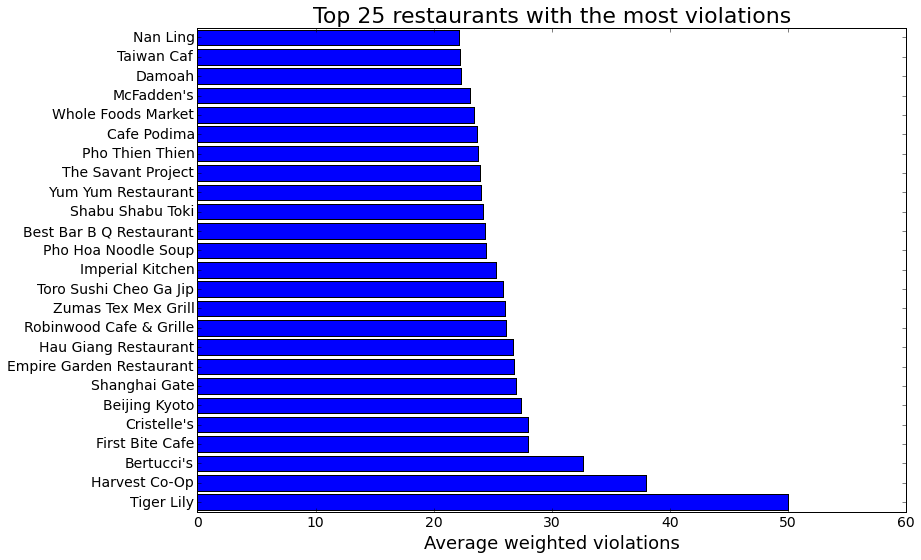

In [10]:
worst25 = biz_violations.sort_values(['weighted_violations_mean'], ascending=False).head(25)
labels = map(lambda x: x.encode('ascii', 'ignore'), worst25.name)

fig, ax = plt.subplots(1, 1, figsize=(13, 8))
plt.barh(range(25), worst25['weighted_violations_mean'], align='center')
plt.xlim(0, 60)
plt.ylim(-0.5, 24.5)
plt.yticks(range(25), labels)
plt.title('Top 25 restaurants with the most violations')
plt.xlabel('Average weighted violations')
plt.tight_layout()

### Let's look for correlations between business properties and the number of violations

(0, 30)

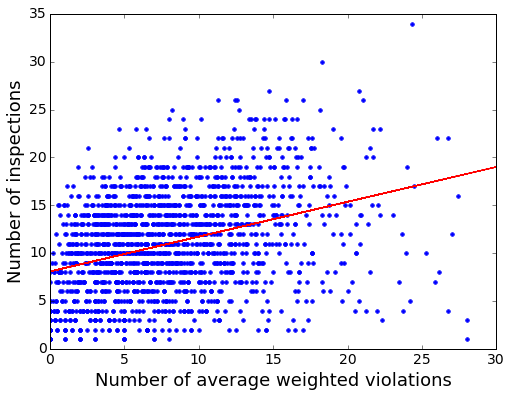

In [11]:
x = biz_violations['weighted_violations_mean']
y = biz_violations['*_size']
m, b = np.polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, m * x + b, 'r-')
plt.xlabel('Number of average weighted violations')
plt.ylabel('Number of inspections')
plt.xlim(0, 30)

In [12]:
from scipy.stats import pearsonr
pearsonr(biz_violations['weighted_violations_mean'], biz_violations['*_size'])

(0.36019076455688287, 1.4422762458847863e-56)

We see that there is a correlation between number of inspections and mean weighted violations. This suggests that inspectors are returning to the restaurants with the worst hygiene.

### Mean violations as a function of the restaurant price range. Are expensive restaurants cleaner in the kitchen?

(0, 5)

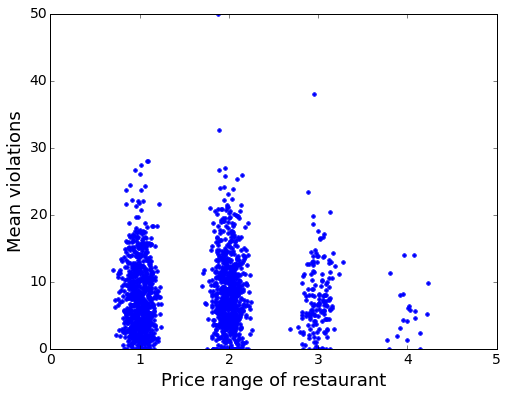

In [13]:
prices = [price + np.random.normal(loc=0.0, scale=0.1) for price in biz_violations[biz_violations['price_range'] != 0].price_range]
plt.plot(prices, biz_violations[biz_violations['price_range'] != 0].weighted_violations_mean, '.')
plt.xlabel('Price range of restaurant')
plt.ylabel('Mean violations')
plt.xlim(0, 5)

In [14]:
pearsonr(biz_violations[biz_violations['price_range'] != 0].price_range, biz_violations[biz_violations['price_range'] != 0].weighted_violations_mean)

(0.0084902153924064517, 0.72075226239132328)

This shows that there is no correlation between the price range of a restaurant and the number of violations.

### Neighborhoods, categories and attributes

Let's look at the mean one-star violations as a function of neighborhood:

In [147]:
violation_label = []
neighborhoods = set(biz_violations['neighborhoods'].sum())
for neighborhood in neighborhoods:
    msk = biz_violations.neighborhoods.apply(lambda x: neighborhood in x)
    violation = biz_violations[msk]['*_mean'].mean()
    _ = biz_violations[~msk]['*_mean'].mean() # this is almost always equal to 3.4
    num_rest = biz_violations[msk]['*_mean'].size
    violation_label.append((violation, neighborhood, num_rest))
violation_label.sort()
violations, labels, num_rest = zip(*violation_label)

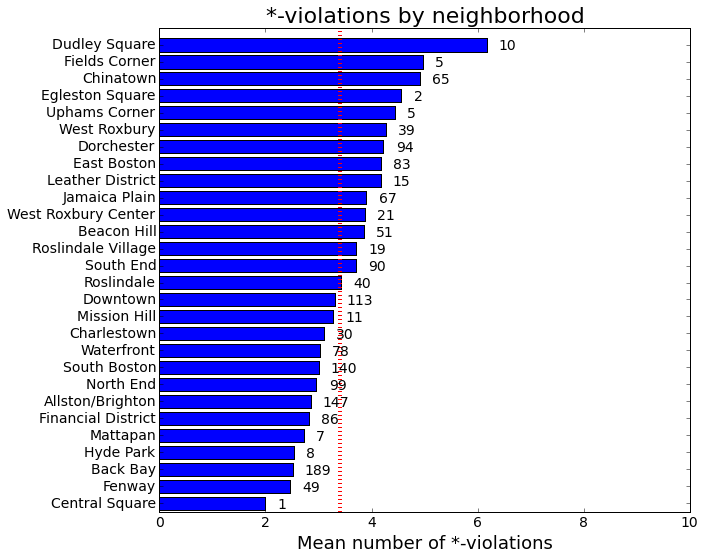

In [148]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plt.barh(range(len(labels)), violations, align='center')
plt.plot([3.4, 3.4], [-0.5, len(labels)], 'r:', lw=4)
for i, (num, vio) in enumerate(zip(num_rest, violations)):
    plt.text(vio + 0.25, i - 0.3, str(num))
plt.xlim(0, 10)
plt.ylim(-0.5, len(labels))
plt.yticks(range(len(labels)), labels)
plt.title('*-violations by neighborhood')
plt.xlabel('Mean number of *-violations')
plt.tight_layout()

In [145]:
violation_label = []
categories = set(biz_violations['categories'].sum())
for category in categories:
    msk = biz_violations.categories.apply(lambda x: category in x)
    violation = biz_violations[msk]['*_mean'].mean()
    _ = biz_violations[~msk]['*_mean'].mean()
    num_rest = biz_violations[msk]['*_mean'].size
    violation_label.append((violation, category, num_rest))
violation_label.sort()
violations, labels, num_rest = zip(*violation_label)

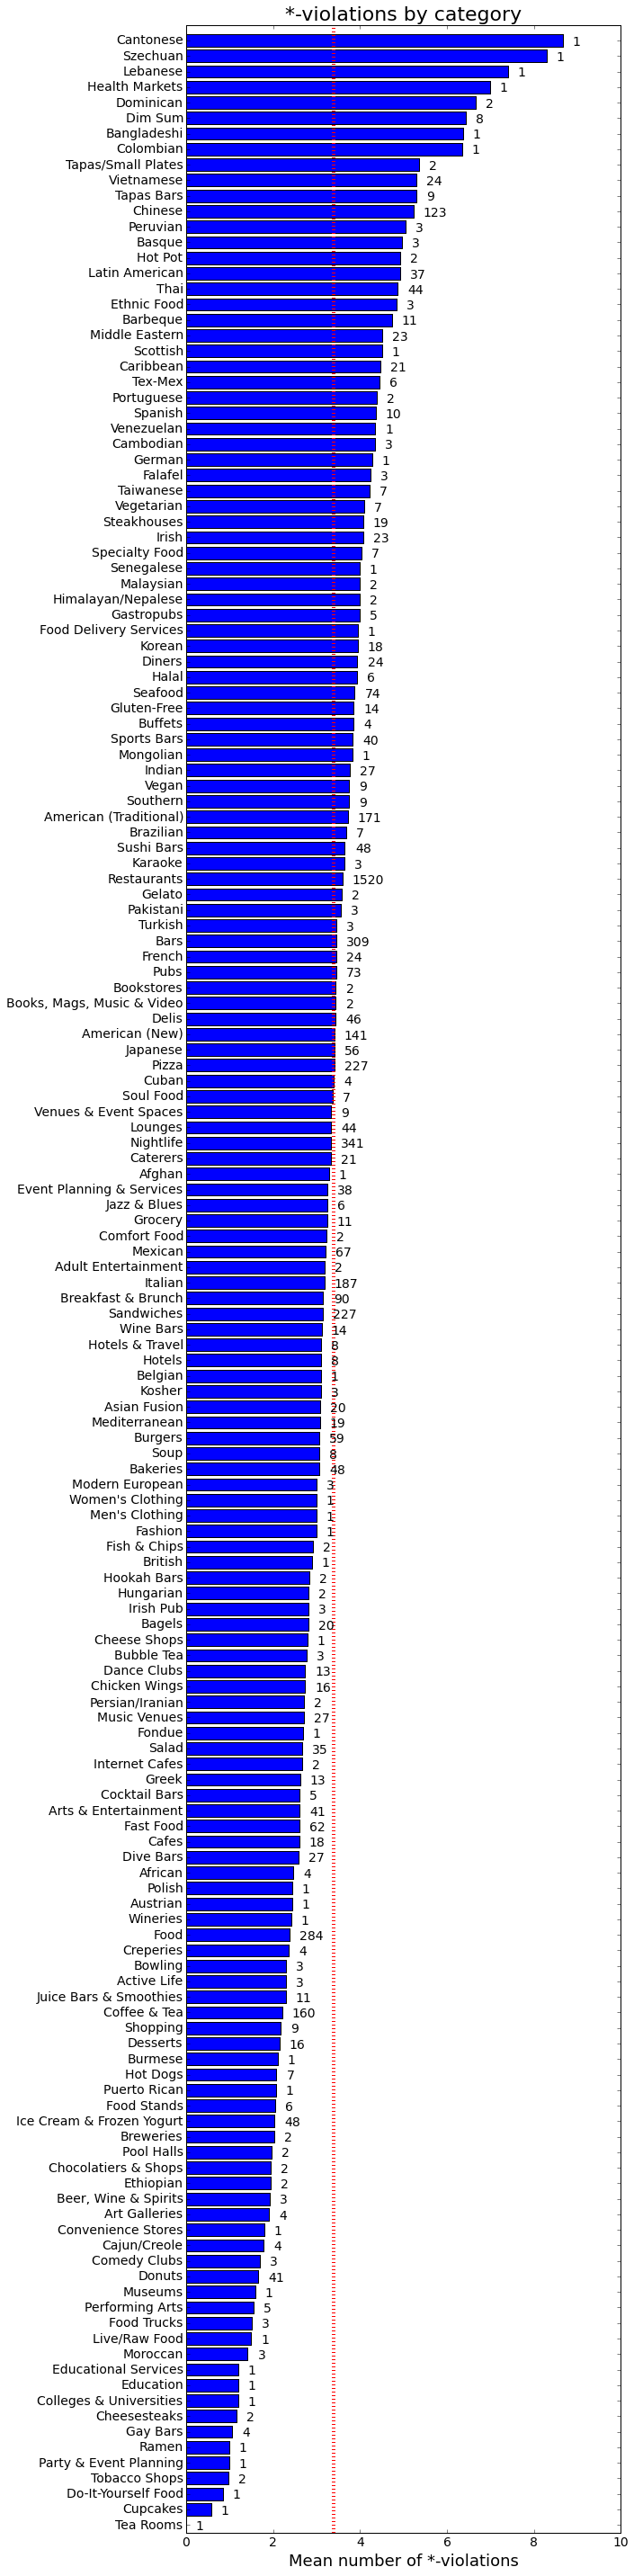

In [146]:
fig, ax = plt.subplots(1, 1, figsize=(10, 40))
plt.barh(range(len(labels)), violations, align='center')
plt.plot([3.4, 3.4], [-0.5, len(labels)], 'r:', lw=4)
for i, (num, vio) in enumerate(zip(num_rest, violations)):
    plt.text(vio + 0.25, i - 0.3, str(num))
plt.xlim(0, 10)
plt.ylim(-0.5, len(labels))
plt.yticks(range(len(labels)), labels)
plt.title('*-violations by category')
plt.xlabel('Mean number of *-violations')
plt.tight_layout()

In [19]:
atts = set(biz_violations['attributes'].apply(lambda x: x.keys()).sum())
atts

{u'Accepts Credit Cards',
 u'Ages Allowed',
 u'Alcohol',
 u'Ambience',
 u'Attire',
 u'BYOB',
 u'BYOB/Corkage',
 u'By Appointment Only',
 u'Caters',
 u'Coat Check',
 u'Corkage',
 u'Delivery',
 u'Dietary Restrictions',
 u'Dogs Allowed',
 u'Drive-Thru',
 u'Good For',
 u'Good For Dancing',
 u'Good For Groups',
 u'Good For Kids',
 u'Good for Kids',
 u'Happy Hour',
 u'Has TV',
 u'Music',
 u'Noise Level',
 u'Open 24 Hours',
 u'Order at Counter',
 u'Outdoor Seating',
 u'Parking',
 u'Payment Types',
 u'Price Range',
 u'Smoking',
 u'Take-out',
 u'Takes Reservations',
 u'Waiter Service',
 u'Wheelchair Accessible',
 u'Wi-Fi'}

In [173]:
for attribute in ['Takes Reservations', 'Has TV', 'Waiter Service', 'Take-out', 'Delivery', 'Coat Check', 'Drive-Thru', 'Open 24 Hours', 'Wheelchair Accessible']:
    msk = biz_violations.attributes.apply(lambda x: attribute in x.keys())
    has_key = biz_violations[msk]
    msk = has_key.attributes.apply(lambda x: x[attribute])
    print attribute, has_key[msk].shape[0], has_key[msk]['*_mean'].mean(), has_key[~msk]['*_mean'].mean()

Takes Reservations 528 3.79708132929 3.52900687
Has TV 687 3.6272294165 3.57475366509
Waiter Service 856 3.86481165416 3.29931661572
Take-out 1370 3.6423809296 3.34255727831
Delivery 490 3.95038569576 3.46380208416
Coat Check 72 3.42912884067 3.56513774722
Drive-Thru 12 2.15873712058 3.10397405482
Open 24 Hours 1 0.0 4.05969299643
Wheelchair Accessible 1258 3.36380967075 3.71750648639


### How does the restaurant star ratings vary with average number of violations?

(0, 6)

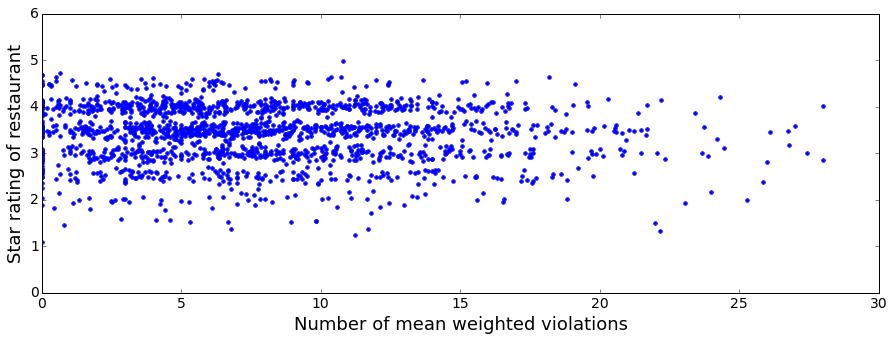

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
star_values = [star + np.random.normal(loc=0.0, scale=0.1) for star in biz_violations.stars]
plt.plot(biz_violations['weighted_violations_mean'], star_values, '.')
plt.xlabel('Number of mean weighted violations')
plt.ylabel('Star rating of restaurant')
plt.xlim(0, 30)
plt.ylim(0, 6)

In [21]:
pearsonr(biz_violations['weighted_violations_mean'], biz_violations.stars)

(-0.086141823784440463, 0.00024339077469063728)

It is surprising that the star rating of the restaurant does not correlate with the mean number of violations. One would think that restaurants with lots of violations would get a low star rating while those with few would have a high rating. This is not borne out in the data.

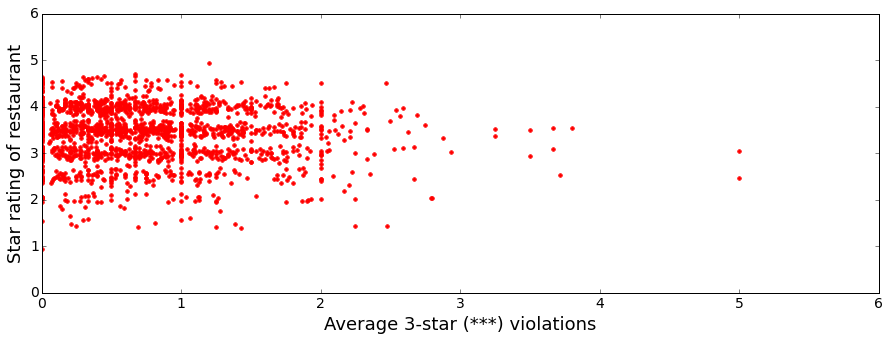

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
star_values = [star + np.random.normal(loc=0.0, scale=0.1) for star in biz_violations.stars]
plt.plot(biz_violations['***_mean'], star_values, '.', color='r')
plt.xlabel('Average 3-star (***) violations')
plt.ylabel('Star rating of restaurant')
plt.xlim(0, 6)
plt.ylim(0, 6)
plt.title('')

In [23]:
pearsonr(biz_violations['***_mean'], biz_violations.stars)

(-0.074182392238399508, 0.0015874956832724616)

### How does the review count vary with violations?

One may suspect that very good and very bad restaurants are the most written about. Again, here it would be nice to normalize by number of patrons per day or size of the restaurant. We do not have this data.

(0, 1500)

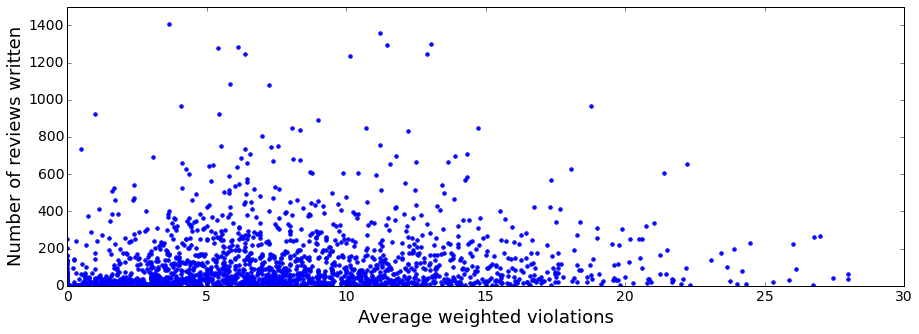

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.plot(biz_violations['weighted_violations_mean'], biz_violations.review_count, '.')
plt.xlabel('Average weighted violations')
plt.ylabel('Number of reviews written')
plt.xlim(0, 30)
plt.ylim(0, 1500)

In [25]:
pearsonr(biz_violations['weighted_violations_mean'], biz_violations.review_count)

(0.05488756070729852, 0.019528334537080558)

(0, 1500)

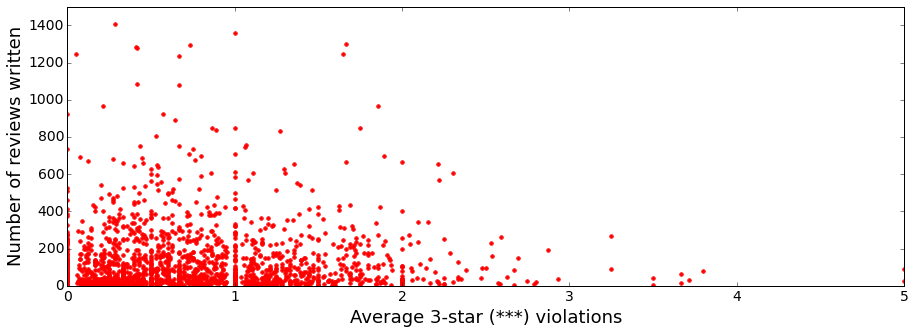

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.plot(biz_violations[('***_mean')], biz_violations.review_count, '.', color='r')
plt.xlabel('Average 3-star (***) violations')
plt.ylabel('Number of reviews written')
plt.xlim(0, 5)
plt.ylim(0, 1500)

In [27]:
pearsonr(biz_violations[('***_mean')], biz_violations.review_count)

(0.03229567014011725, 0.169628308089629)

### Locations

We load the locations of the fire departments from https://www.cityofboston.gov/maps/:

In [136]:
df_fire = pd.read_csv('Fire_Departments.csv', encoding='utf_8-sig')

We look at the restaurants are grouped by neighborhood:

In [28]:
df_biz.groupby('city').size()

city
Allston               105
Boston               1386
Brighton               94
Cambridge               1
Charlestown            29
Chestnut Hill           2
Dorchester             80
Dorchester Center      12
East Boston            17
Hyde Park               7
Jamaica Plain          71
Mattapan                5
Mission Hill            1
Roslindale             34
Roxbury                24
Roxbury Crossing       12
South Boston           12
West Roxbury           38
dtype: int64

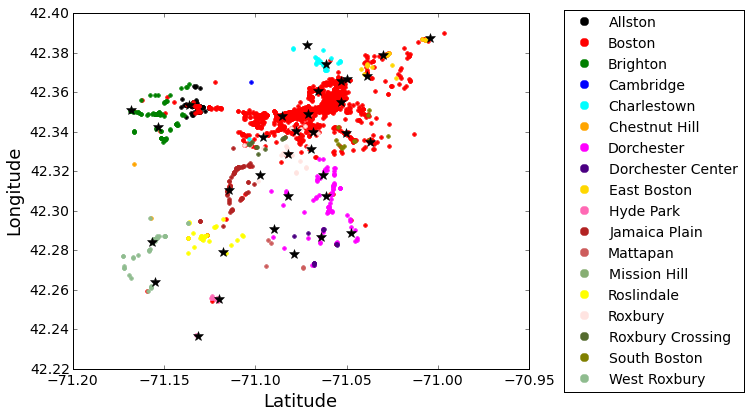

In [135]:
import matplotlib
colors, _ = zip(*matplotlib.colors.cnames.iteritems())
colors = ['black', 'red', 'green', 'blue', 'cyan', 'orange', 'magenta'] + list(colors)
for i, c in enumerate(np.sort(df_biz.city.unique())):
    plt.plot(df_biz[df_biz.city == c].longitude, df_biz[df_biz.city == c].latitude, '.', color=colors[i], label=c)
plt.plot(df_fire.X, df_fire.Y, 'k*', ms=10)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend(bbox_to_anchor=(1.5, 1.05), markerscale=2)
plt.tight_layout()

### Conclusions

As stated above, the business data do not give significant insight into predicting health inspection violations. It's time to create a model based on the user reviews and we do that in Part 3.